pip install -U deepctr-torch

In [2]:
import pandas as pd
import torch
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

Please check the latest version manually on https://pypi.org/project/deepctr-torch/#history


In [3]:
data = pd.read_csv('./criteo_sample.txt')

In [4]:
data.columns

Index(['label', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10',
       'I11', 'I12', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18',
       'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26'],
      dtype='object')

<AxesSubplot:>

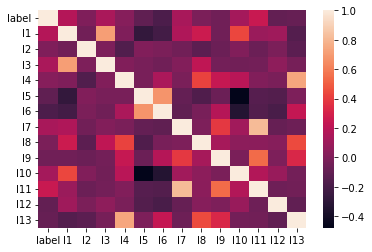

In [5]:
sns.heatmap(data.corr())

In [6]:
sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I' + str(i) for i in range(1, 14)]

In [7]:
data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0, )

In [8]:
target = ['label']

In [9]:
for feat in sparse_features:
    data[feat] = LabelEncoder().fit_transform(data[feat])

In [10]:
data[dense_features] = MinMaxScaler(feature_range=(0, 1)).fit_transform(data[dense_features])

In [11]:
len(data)

200

In [12]:
while len(data) < 100000:
    print("#", end="")
    data = data.append(data)

#########

In [13]:
len(data)

102400

In [14]:
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique()) for feat in sparse_features] + \
                         [DenseFeat(feat, 1, ) for feat in dense_features]

In [15]:
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [16]:
data.shape

(102400, 40)

In [17]:
train, test = train_test_split(data, test_size=0.15)

In [18]:
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

In [19]:
device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

cuda ready...


In [20]:
model = DeepFM(linear_feature_columns=linear_feature_columns, dnn_feature_columns=dnn_feature_columns,
               task='binary', l2_reg_embedding=1e-5, device=device)

In [21]:
model.compile("adagrad", "binary_crossentropy", metrics=["binary_crossentropy", "auc"], )

In [23]:
from time import time
t_start = time()
model.fit(train_model_input,train[target].values, batch_size=20000, epochs=10, verbose=2,validation_split=0)
print(f"common time: {time() - t_start}")
print(f"for one sample: {(time() - t_start) / len(train)}")

cuda:0
Train on 87040 samples, validate on 0 samples, 5 steps per epoch
Epoch 1/10
3s - loss:  0.0002 - binary_crossentropy:  0.0002 - auc:  1.0000
Epoch 2/10
2s - loss:  0.0002 - binary_crossentropy:  0.0002 - auc:  1.0000
Epoch 3/10
2s - loss:  0.0002 - binary_crossentropy:  0.0002 - auc:  1.0000
Epoch 4/10
2s - loss:  0.0002 - binary_crossentropy:  0.0002 - auc:  1.0000
Epoch 5/10
2s - loss:  0.0001 - binary_crossentropy:  0.0001 - auc:  1.0000
Epoch 6/10
2s - loss:  0.0001 - binary_crossentropy:  0.0001 - auc:  1.0000
Epoch 7/10
2s - loss:  0.0001 - binary_crossentropy:  0.0001 - auc:  1.0000
Epoch 8/10
2s - loss:  0.0001 - binary_crossentropy:  0.0001 - auc:  1.0000
Epoch 9/10
2s - loss:  0.0001 - binary_crossentropy:  0.0001 - auc:  1.0000
Epoch 10/10
2s - loss:  0.0001 - binary_crossentropy:  0.0001 - auc:  1.0000
common time: 27.645812273025513
for one sample: 0.00031762192409266445


In [241]:
pred_ans = model.predict(test_model_input, batch_size=512)
print("")
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))


test LogLoss 0.8631
test AUC 0.4339


In [ ]:
# DeepFM 0.6772
# AFM 0.36
# xDeepFM 0.4339
# AutoInt 0.5238
# FiBiNET 0.444


In [164]:
data.label.mean()

0.245

In [ ]:
# написать lightFM baseline?